In [1]:
from pathlib import Path
import pandas as pd
import altair as alt
from IPython.display import HTML

In [2]:
def latest_file(path: Path, pattern: str = "*"):
    files = path.glob(pattern)
    return max(files, key=lambda x: x.stat().st_ctime)

In [3]:
particle_path = latest_file(Path('results_csv/'),'particle_results*.csv')
print (f'Particle file used is:   {particle_path.name}')

wafer_path = latest_file(Path('results_csv/'),'wafer_results*.csv')
print (f'Wafer file used is:   {wafer_path.name}')

snips_path = latest_file(Path('results_csv/'),'particle_snips*.csv')
print (f'Snips file used is:   {snips_path.name}')

Particle file used is:   particle_results_28-12-20_03-58.csv
Wafer file used is:   wafer_results_28-12-20_03-58.csv
Snips file used is:   particle_snips_28-12-20_03-58.csv


In [4]:
# Particle data to Long format: Version B
#%%time
particle_results = pd.read_csv(particle_path)
particle_results_matched_only = particle_results.dropna()  # only used for calculating aggregated areas in wafer results
particle_results.rename(columns={'preIndex': '_preIndex',
                                 'wafer': '_wafer',
                                 'polymer': '_polymer',
                                 'treatment': '_treatment',
                                 'postIndex': '_postIndex'}, inplace=True)
pa = pd.DataFrame(particle_results.values, columns=particle_results.columns.str.rsplit('_', 1, expand=True))
# pa.rename(columns={'_area': 'area', '_perimeter': 'perimeter', '_intensities': 'mean_intensity'}, level=0, inplace=True)
#pa.rename(columns={'intensities': 'mean_intensity'}, level=0, inplace=True)

pam = pa.melt(id_vars=[
    ('', 'wafer'), 
    ('', 'polymer'), 
    ('', 'treatment'), 
    ('', 'preIndex'), 
    ('', 'postIndex')], 
                value_vars=[
                    ('area', 'pre'), 
                    ('area', 'post'), 
                    ('perimeter', 'pre'), 
                    ('perimeter', 'post'), 
                    ('intensity', 'pre'), 
                    ('intensity', 'post')])

pam.set_index('variable_1', inplace=True)
postValuesSeries = pam.loc['post', 'value']
pam.drop(index='post', inplace=True)
pam['postValue'] = postValuesSeries.values
pam.reset_index(drop=True, inplace=True)
pam.columns = ['wafer', 'polymer', 'treatment', 'preIndex', 'postIndex', 'prop', 'preValue', 'postValue']

# pam['matched'] = ~pam.preIndex.isna() & ~pam.postIndex.isna()

In [5]:
wafer_results = pd.read_csv(wafer_path)

particle_wafer_groups = particle_results_matched_only.groupby('wafer')  # grouping by wafer: only particles that matched between pre and post are used here
for _, group_content in particle_wafer_groups:  # cycle through polymer groups
    pre_area_matched_mean = group_content.area_pre.mean()
    wafer_results.loc[(wafer_results.wafer == group_content.wafer.unique()[0]), 'pre_area_matched'] = round(pre_area_matched_mean)
    post_area_matched_mean = group_content.area_post.mean()
    wafer_results.loc[(wafer_results.wafer == group_content.wafer.unique()[0]), 'post_area_matched'] = round(post_area_matched_mean)


wafer_results.dropna(inplace=True)  # drop any lines were there were no results
# wafer_results.drop(wafer_results[wafer_results.treatment == 'HCl'].index, inplace=True)  # drop HCl treatment (this was only used for calibration)
# wafer_results.drop(wafer_results[wafer_results.polymer == 'PMMA'].index, inplace=True)

wafer_results['particle_loss'] = round((wafer_results.matched_count / wafer_results.pre_count - 1) * 100) # Get normalised count ratios for each wafer: counts of particles in pre state divided by counts in post state. Subtract 1 to normalise. Take absolute value to treat particle loss and particle addition as the same. Multiply by 100 to get percent values.
wafer_results['area_change'] = round((wafer_results.post_area_matched / wafer_results.pre_area_matched - 1) * 100)  # same for area...

wafer_polymer_groups = wafer_results.groupby('polymer')  # group by polymers

wafer_results_wrangled =pd.DataFrame()  # create empty df to fill in results from loop
for _, group_content in wafer_polymer_groups:  # cycle through polymer groups
        
    group_content['particle_loss_waterCorrected'] = group_content.loc[group_content.treatment != 'water', 'particle_loss'] - group_content.loc[group_content.treatment == 'water', 'particle_loss'].iloc[0]  # subtract count ratio of water from count ratios of all other treatments to get the percentage point error (meaning loss OR addition) of particle numbers caused by each treatment 
    group_content['area_change_waterCorrected'] = group_content.loc[group_content.treatment != 'water', 'area_change'] - group_content.loc[group_content.treatment == 'water', 'area_change'].iloc[0]  # same for area
        
    #group_content.drop(group_content[group_content.treatment == 'water'].index, inplace=True)  # the rows with the water treatments can now be deleted
        
# following line is good example how to not get into "set with copy" warning. Also several bool conditions could be used like that: df.loc[(df['A'] == 'blue') & (df['B'] == 'red') & (df['C'] == 'square'),'D'] = 'M5' (found here: https://stackoverflow.com/questions/21263020/pandas-update-value-if-condition-in-3-columns-are-met)
    group_content.loc[(group_content['particle_loss_waterCorrected'] > 0), 'particle_loss_waterCorrected'] = 0  # set all ratios that were smaller than water ratio (and thus got now positive due to water ratio correction) to 0.
#     group_content.loc[(group_content['area_change_waterCorrected'] > 0), 'area_change_waterCorrected'] = 0  # same for area
    
    wafer_results_wrangled = wafer_results_wrangled.append(group_content)  # save results to df
melted_wafers = wafer_results_wrangled.melt(id_vars=[
    'wafer',
    'polymer',
    'treatment',
    'pre_count',
    'post_count',
    'matched_count',
    'pre_area_matched',
    'post_area_matched'
    ], value_vars=[
    'particle_loss', 'area_change', 'particle_loss_waterCorrected', 'area_change_waterCorrected'], var_name='Property', value_name='percent_change')

In [6]:
particle_snips = pd.read_csv(snips_path)

In [7]:
# ===================
# Altair result plots
# ===================

# Preparations
# ------------
alt.data_transformers.disable_max_rows()  # make altair plot DFs with more than 5000 rows
display(HTML("""
<style>
.vega-bind {
  text-align:right;
}
.vega-bind ~ .vega-bind {
  text-align:left;
}
</style>
"""))  # Preparing CSS placement of selectors


# Interactive selections
# ----------------------
pickedX = alt.selection_single(encodings=['x'], empty='none')  # , on='mouseover', clear='mouseout')  # selection of type "single" allows clicking of one element in one plot to filter other plots
pickedY = alt.selection_single(encodings=['y'], empty='none')  # , on='mouseover', clear='mouseout')  # selection of type "single" allows clicking of one element in one plot to filter other plots
partpic = alt.selection_single(fields=['wafer', 'polymer', 'treatment', 'preIndex', 'postIndex'], empty='none')
heatmapprop_dropdown = alt.binding_select(options=['particle_loss', 'area_change', 'particle_loss_waterCorrected', 'area_change_waterCorrected'], name='Heatmap property')
heatmapprop_select = alt.selection_single(fields=['Property'], 
                                          bind=heatmapprop_dropdown, 
                                          init={'Property': 'particle_loss_waterCorrected'}, 
                                          clear=False, 
                                          on="click[event.shiftKey&!event.shiftKey]")
particleprop_dropdown = alt.binding_select(options=['area', 'perimeter', 'intensity'], name='Particle property')
particleprop_select = alt.selection_single(fields=['prop'], bind=particleprop_dropdown, init={'prop': 'area'})


# Quant Heatmap
# -------------
wafer_side = alt.Chart(melted_wafers).mark_rect().encode(
    x=alt.X('treatment:N', sort=['water', 'H2O2', 'KOH', 'Pentane', 'SPT', 'HCl'], axis=alt.Axis(title=None, orient="top", domain=False)),
    y=alt.Y('polymer:N', sort=['ABS', 'EVA', 'LDPE', 'PA6', 'PC', 'PET', 'PP', 'TPU', 'Acrylate paint', 'Epoxy'], axis=alt.Axis(title=None, orient="left", domain=False)),
    color=alt.Color(
        'percent_change:Q',
        scale=alt.Scale(scheme='lightmulti', domain=(-100, 0), clamp=True),  #color scheme similar to quali heatmap: 'lighttealblue', for +/- changes: 'redblue'
        sort='descending',
        legend=alt.Legend(title=['Change', '+/- [%]'], gradientLength=350, orient='left', titlePadding=20)),  # , gradientLabelOffset=10)),
    tooltip = alt.Tooltip(['wafer', 'pre_count', 'post_count', 'matched_count', 'pre_area_matched', 'post_area_matched', 'percent_change:Q'])
).add_selection(
    heatmapprop_select
).transform_filter(
    heatmapprop_select
).add_selection(
    pickedY,
    pickedX
).properties(
    height=500, width=150
)


# Scatter plot
# ------------
particleScatter = alt.Chart(pam).mark_circle(size=100).encode(
    x='preValue',
    y='postValue',
    tooltip=alt.Tooltip(['preIndex', 'postIndex', 'preValue', 'postValue'])
).transform_filter(
    pickedX & pickedY
)

waterScatter = alt.Chart(pam).mark_circle(color='grey', opacity=0.3).encode(
    x='preValue',
    y='postValue'
).transform_filter(
    {'and': [pickedY, alt.FieldEqualPredicate(field='treatment', equal='water')]}
)

particleLinReg = particleScatter.transform_regression('preValue', 'postValue',method="linear"
).mark_line(color="orange", clip=True)

waterLinReg = waterScatter.transform_regression('preValue', 'postValue',method="linear"
).mark_line(color="grey", clip=True)

# band = alt.Chart(pam).mark_errorband(extent='ci').encode(
#     x='preValue',
#     y='postValue'
# )

identityLine = alt.Chart(pam).mark_line(color= 'black', strokeDash=[3,8], clip=True).encode(
    x=alt.X('preValue', axis=alt.Axis(title='')),
    y=alt.Y('preValue', axis=alt.Axis(title=''))
)

texts = alt.Chart().mark_text(dy=-180, size=12).encode(
    text='label:N'
).transform_calculate(label='datum.treatment + " on " + datum.polymer'
).transform_filter(
    pickedX & pickedY
)


# Boxplot
# -------
boxPlot = alt.Chart(pam).transform_calculate(
    Change='(datum.postValue / datum.preValue -1)'
).mark_boxplot(extent=0.5, outliers=True, clip=True).encode(
    x='treatment',
    y=alt.Y('Change:Q', axis=alt.Axis(format='%'), 
            scale=alt.Scale(domain=(-1, 1)))
).transform_filter(
    particleprop_select
).transform_filter(
    {'and': [pickedY, {'or': [pickedX, alt.FieldEqualPredicate(field='treatment', equal='water')]}]}
)


# Particle snip images
# --------------------
snipPre = alt.Chart().mark_image(
    width=150,
    height=150
).encode(
    url = 'snip_pre:N'
).transform_filter(
    partpic
).properties(title='Pre Treatment'
)


snipPost = alt.Chart().mark_image(
    width=150,
    height=150
).encode(
    url = 'snip_post:N'
).transform_filter(
    partpic
).properties(title='Post Treatment'
)


# Putting plots together
# ----------------------
scatterAll = (particleScatter.add_selection(partpic) + particleLinReg + waterScatter + waterLinReg + identityLine + texts
).add_selection(
    particleprop_select
).transform_filter(
    particleprop_select
).properties(
    width=300,
    height=300
)

snips = alt.hconcat(snipPre, snipPost, data=particle_snips)

particle_side = alt.vconcat(scatterAll | boxPlot, snips, center=True)

quant_fig = alt.hconcat(wafer_side, particle_side,
                                padding={"left": 50, "top": 50, "right": 50, "bottom": 50},
                                spacing=50
).configure_scale(bandPaddingInner=0.1  # set space between heatmap tiles
# ).configure_title(orient='bottom', offset=20  # configure title of plot
).configure_view(
    strokeWidth=0  # get rid of chart box
)

quant_fig.save('figures/quant_results.html')

In [47]:
# TRY: Heatmap from "pam" (melted particle results instead of wide)

# Drop data to be excluded:
pam.drop(pam[pam.wafer=='w20'].index, inplace=True)  # acid calibration sample
bad_wafers = [69, 70, 71, 72, 73, 94, 95, 99, 100, 44]
for w in bad_wafers:
    pam.drop(pam[pam.wafer=='w'+str(w)].index, inplace=True)


#waferprop_radio = alt.binding_radio(options=['countRatios', 'areaRatios'], name='Wafer property:   ', empty=None)
#waferprop_select = alt.selection_single(fields=['variable'], bind=waferprop_radio)

#brush = alt.selection_interval(encodings=['x', 'y'])  # selection of type "interval"



alt.Chart(pam).transform_joinaggregate(
    numPre='valid(preIndex)',
    numPost='valid(postIndex)',
    numMatched='valid(preIndex & postIndex)',
    groupby=['wafer', 'prop']
).transform_calculate(
    countRatios='round((datum.numPost / datum.numPre -1) *10 *10)'
).mark_rect().encode(
    x=alt.X('treatment:N', axis=alt.Axis(title=None, orient="top", domain=False)),
    y=alt.Y('polymer:N', axis=alt.Axis(title=None, orient="left", domain=False)),
    color=alt.Color(
        'mean(countRatios):Q',  # 'mean(percent_change):Q',  # use in combination with heatmap property seletion (also activate transfom_fold)
        scale=alt.Scale(scheme='lightmulti', domain=(-30, 0), clamp=True),  #color scheme similar to quali heatmap: 'lighttealblue', for +/- changes: 'redblue'
        sort='descending',
        legend=alt.Legend(
            title=['Change', '+/- [%]'])),
    tooltip = alt.Tooltip(['wafer','numPre:N','numPost:N','countRatios:Q'])
).add_selection(
    pickedY,
    pickedX
).properties(
    height=400, width=150
)#.add_selection(
#     brush
# ).add_selection(
#     waferprop_select
# ).transform_filter(
#     waferprop_select
# )



alt.Chart(...)

In [12]:
# Particle results in wide format are used for heatmap (melting to long by altair "transform_fold")
# first preparing particles DF:
particle_results = pd.read_csv(particle_path)
# Drop data to be excluded:
particle_results.drop(particle_results[particle_results.wafer=='w20'].index, inplace=True)  # acid calibration sample
bad_wafers = [65, 32, 34, 37, 96, 97, 69, 70, 71, 72, 73, 94, 95, 99, 100, 44]
for w in bad_wafers:
    particle_results.drop(particle_results[particle_results.wafer=='w'+str(w)].index, inplace=True)

particle_results.rename(columns={'Unnamed: 0': 'preIndex', 'postIndices': 'postIndex'}, inplace=True)
paw = particle_results.copy()
paw['mean particle area'] = round((paw['area_post'] / paw['area_pre'] -1) *10) *10
paw['mean particle perimeter'] = round((paw['perimeter_post'] / paw['perimeter_pre'] -1) *10) *10
paw['mean particle brightness'] = round((paw['intensity_post'][0] / paw['intensity_pre'][0] -1) *10) *10

alt.data_transformers.disable_max_rows()  # make altair plot DFs with more than 5000 rows


# Interactive selections
# ----------------------
pickedX = alt.selection_single(encodings=['x'], empty='none')  # selection of type "single" allows clicking of one element in one plot to filter other plots
pickedY = alt.selection_single(encodings=['y'], empty='none')  # selection of type "single" allows clicking of one element in one plot to filter other plots
# derivedColumns = ['particle_count', 'mean particle area', 'mean particle perimeter', 'mean particle brightness']
# heatmapprop_dropdown = alt.binding_select(options=derivedColumns, name='Heatmap property')
# heatmapprop_select = alt.selection_single(fields=['Property'], 
#                                           bind=heatmapprop_dropdown, 
#                                           init={'Property': 'particle_count'}, 
#                                           clear=False, 
#                                           on="click[event.shiftKey&!event.shiftKey]"
#                                          )
particleprop_dropdown = alt.binding_select(options=['area', 'perimeter', 'intensity'], name='Particle property')
particleprop_select = alt.selection_single(fields=['prop'], bind=particleprop_dropdown, init={'prop': 'area'})


# Quant Heatmap
# -------------
quantHM = alt.Chart(paw).transform_joinaggregate(
    numPre='valid(preIndex)',
    numPost='valid(postIndex)',
    groupby=['wafer']
).transform_calculate(
    particle_count='round((datum.numPost / datum.numPre -1) *10 *10)'
# ).transform_fold(
#     derivedColumns,
#     as_=['Property', 'value']
).mark_rect().encode(
    x=alt.X('treatment:N', axis=alt.Axis(title=None, orient="top", domain=False, ticks=False)),
    y=alt.Y('polymer:N', axis=alt.Axis(title=None, orient="left", domain=False, ticks=False)),
    color=alt.Color(
        'mean(particle_count):Q',  # 'mean(value):Q',  # use in combination with heatmap property seletion (also activate transfom_fold)
        scale=alt.Scale(scheme='lightmulti', domain=(-30, 0), clamp=True),  #color scheme similar to quali heatmap: 'lighttealblue', for +/- changes: 'redblue'
        sort='descending',
        legend=alt.Legend(
            title=['Change', '+/- [%]'])
    ),
    tooltip = alt.Tooltip(['wafer', 'mean(particle_count):Q', 'numPre:Q', 'numPost:Q']),
#     tooltip = alt.Tooltip(['wafer','mean(value):Q','Property:N', 'numPre:Q', 'numPost:Q']),
    size='numPre:Q'
# ).add_selection(
#     heatmapprop_select
# ).transform_filter(
#     heatmapprop_select
).add_selection(
    pickedY,
    pickedX
).properties(
    height=400, width=150
)


countScatter = alt.Chart(paw).transform_joinaggregate(
    numPre='valid(preIndex)',
    numPost='valid(postIndex)',
    groupby=['wafer']
).mark_point().encode(
    x=alt.X('numPre:Q', scale=alt.Scale(type='log')),
    y=alt.Y('numPost:Q', scale=alt.Scale(type='log')),
    tooltip = alt.Tooltip(['wafer:N', 'polymer:N', 'treatment:N', 'numPre:Q', 'numPost:Q'])
)

In [22]:
color_sel = alt.selection_multi(fields=['treatment'], bind='legend')

changeVScounts = alt.Chart(wafer_results_wrangled).mark_circle(size=100).encode(
    alt.X(alt.repeat('column'), type='quantitative'),
    alt.Y(alt.repeat('row'), type='quantitative', sort='descending'),
    color='treatment:N',
    tooltip=['wafer', 'polymer', 'treatment', alt.Tooltip(alt.repeat('column'), type='quantitative'), alt.Tooltip(alt.repeat('row'), type='quantitative')],
    opacity=alt.condition(color_sel, alt.value(1), alt.value(0.2))
).repeat(
    column=['pre_count', 'matched_count', 'post_count'],
    row=['particle_loss_waterCorrected', 'area_change_waterCorrected']
).add_selection(
    color_sel)

changeVScounts.save('figures/changeVScounts_waterCorrected.html')

In [ ]:
mode = alt.binding_radio(options=['water-corrected', 'non-corrected'], name='Mode')
mode_select = alt.selection_single(fields=['Mode'], bind=mode, init={'Mode': 'water-corrected'})
treatment_emphasis = alt.selection_multi(fields=['treatment'], bind='legend')

alt.Chart(wafer_results_wrangled).transform_fold(
    ['particle_loss', 'particle_loss_waterCorrected'],
    as_=['count_mode', 'count_value']
).transform_fold(
    ['area_change', 'area_change_waterCorrected'],
    as_=['area_mode', 'area_value']
).mark_circle(size=100).encode(
    alt.X(alt.repeat('column'), type='quantitative'),
    alt.Y(alt.repeat('row'), type='quantitative', sort='descending'),
    color='treatment:N',
    tooltip=['wafer', 'polymer', 'treatment', alt.Tooltip(alt.repeat('column'), type='quantitative'),'particle_loss_waterCorrected'],
    opacity=alt.condition(color_sel, alt.value(1), alt.value(0.2))
).repeat(
    column=['pre_count', 'matched_count', 'post_count'],
    row=['count_value', 'area_value']
).add_selection(
    treatment_emphasis
).add_selection(
    mode_select
)



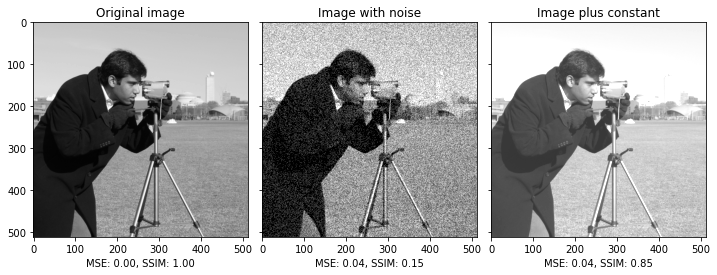

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


img = img_as_float(data.camera())
rows, cols = img.shape

noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1

img_noise = img + noise
img_const = img + abs(noise)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min())

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min())

label = 'MSE: {:.2f}, SSIM: {:.2f}'

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(label.format(mse_none, ssim_none))
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(label.format(mse_noise, ssim_noise))
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(label.format(mse_const, ssim_const))
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()